In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c cascade-cup-22

 53% 9.00M/16.9M [00:00<00:00, 83.6MB/s]
100% 16.9M/16.9M [00:00<00:00, 82.0MB/s]
  0% 0.00/317k [00:00<?, ?B/s]
100% 317k/317k [00:00<00:00, 10.2MB/s]
  0% 0.00/4.31M [00:00<?, ?B/s]
100% 4.31M/4.31M [00:00<00:00, 39.5MB/s]


In [ ]:
! unzip "/content/sample_submission.csv.zip"
! unzip "/content/test.csv.zip"
! unzip "/content/train.csv.zip"

Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier

In [ ]:
train_data=pd.read_csv("/content/train.csv")
train_data['accept_time']=pd.to_datetime(train_data.accept_time)
train_data['order_time']=pd.to_datetime(train_data.order_time)
train_data['order_date']=pd.to_datetime(train_data.order_date)
train_data['allot_time']=pd.to_datetime(train_data.allot_time)
train_data['accept_time']=train_data.accept_time.dt.minute+(train_data.accept_time.dt.hour*60)
train_data['order_time']=train_data.order_time.dt.minute+(train_data.order_time.dt.hour*60)
train_data['allot_time']=train_data.allot_time.dt.minute+(train_data.allot_time.dt.hour*60)
train_data['order_date']=train_data.order_date.dt.dayofyear
a=train_data['accept_time']
b=train_data['order_time']
c=train_data['allot_time']
train_data['diff1']=abs(a-b)
train_data['diff2']=abs(c-b)
train_data['diff3']=abs(c-b)
train_data['total_distance']=train_data['first_mile_distance']+train_data['last_mile_distance']
train_data1=train_data.copy()
train_data=train_data.drop(['accept_time','order_time','allot_time','pickup_time','reassigned_order','first_mile_distance','last_mile_distance','order_date','order_id','lifetime_order_count'],axis=1)
train_data = train_data.sort_values(by = 'rider_id')

In [ ]:
correlation=train_data.corr()
print(correlation['cancelled'].sort_values())

alloted_orders       -0.034491
delivered_orders     -0.030220
session_time         -0.019963
undelivered_orders    0.007417
total_distance        0.020063
rider_id              0.058096
diff1                 0.138632
diff2                 0.147037
diff3                 0.147037
cancelled             1.000000
Name: cancelled, dtype: float64


In [ ]:
def preprocessing_inputs(df):
  df=df.copy()
  missing_columns = df.loc[:, df.isna().mean() >= 0.25].columns
  df = df.drop(missing_columns, axis=1)
  x={column:type(df[column][0]) for column in df.columns}
  rem_col=[]
  for i in x.keys():
    if(x[i]==type('str')):
      rem_col.append(i)
  df=df.drop(rem_col,axis=1)
  rna = df.loc[:, df.isna().sum() > 0].columns
  for y in rna:
    df[y] = df[y].fillna(df[y].mean())
  y=df['cancelled'].copy()
  x=df.drop('cancelled',axis=1).copy()
  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=123)
  ros = RandomOverSampler(random_state=42)
  x_train, y_train = ros.fit_resample(x_train, y_train)
  scaler = StandardScaler()
  scaler.fit(x_train)
  x_train = pd.DataFrame(scaler.transform(x_train), columns=x.columns)
  x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
  return x_train,y_train,x_test,y_test


In [ ]:
x_train,y_train,x_test,y_test=preprocessing_inputs(train_data)

In [ ]:
x_train.shape,y_train.shape

((622630, 9), (622630,))

In [ ]:
model=LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression()

In [ ]:
from lightgbm import LGBMClassifier
model1 = LGBMClassifier()
model1.fit(x_train, y_train)

LGBMClassifier()

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [ ]:
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier()

In [ ]:
model3=KNeighborsClassifier(n_neighbors=5)
model3.fit(x_train,y_train)

KNeighborsClassifier()

In [ ]:
model_acc = model.score(x_test, y_test)
print("Test Accuracy: {:.2f}%".format(model_acc * 100))

Test Accuracy: 85.01%


In [ ]:
test_data=pd.read_csv('/content/test.csv')
td=test_data.copy()
test_data['accept_time']=pd.to_datetime(test_data.accept_time)
test_data['order_time']=pd.to_datetime(test_data.order_time)
test_data['order_date']=pd.to_datetime(test_data.order_date)
test_data['allot_time']=pd.to_datetime(test_data.allot_time)
test_data['accept_time']=test_data.accept_time.dt.minute+(test_data.accept_time.dt.hour*60)
test_data['order_time']=test_data.order_time.dt.minute+(test_data.order_time.dt.hour*60)
test_data['allot_time']=test_data.allot_time.dt.minute+(test_data.allot_time.dt.hour*60)
test_data['order_date']=test_data.order_date.dt.dayofyear
a=test_data['accept_time']
b=test_data['order_time']
c=test_data['allot_time']
test_data['diff1']=abs(a-b)
test_data['diff2']=abs(c-b)
test_data['diff3']=abs(c-b)
test_data['total_distance']=test_data['first_mile_distance']+test_data['last_mile_distance']
test_data=test_data.drop(['accept_time','order_time','allot_time','reassigned_order','last_mile_distance','first_mile_distance','order_date','order_id','lifetime_order_count'],axis=1)
missing_columns = test_data.loc[:,test_data.isna().mean() >= 0.25].columns
test_data = test_data.drop(missing_columns, axis=1)
x={column:type(test_data[column][0]) for column in test_data.columns}
rem_col=[]
for i in x.keys():
  if(x[i]==type('str')):
    rem_col.append(i)
test_data=test_data.drop(rem_col,axis=1)
rna = test_data.loc[:, test_data.isna().sum() > 0].columns
for y in rna:
  test_data[y] = test_data[y].fillna(test_data[y].mean())

In [ ]:
x_train.columns

Index(['rider_id', 'alloted_orders', 'delivered_orders', 'undelivered_orders',
       'session_time', 'diff1', 'diff2', 'diff3', 'total_distance'],
      dtype='object')

In [ ]:
for i in x_train.columns:
  if(i not in test_data.columns):
    print(i)


In [ ]:
predictions=model.predict(test_data)
submissison=td[['order_id']]
submissison['cancelled']=predictions
submissison

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,order_id,cancelled
0,130231,1
1,130232,0
2,130233,0
3,130234,0
4,130235,1
...,...,...
144839,41184,0
144840,41185,1
144841,41186,0
144842,41187,0


In [ ]:
submissison['cancelled'].sum()

62941

In [ ]:
submissison.to_csv("/content/submission21.csv")

In [ ]:
x_train.isna().sum()

order_date            0
alloted_orders        0
delivered_orders      0
undelivered_orders    0
session_time          0
diff1                 0
diff2                 0
diff3                 0
total_distance        0
dtype: int64

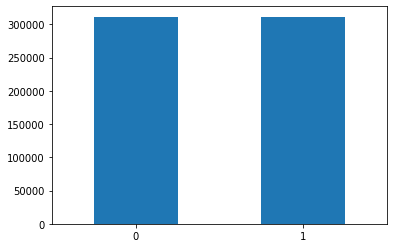

In [ ]:
count=pd.value_counts(y_train,sort=True)
count.plot(kind='bar',rot=0)


In [ ]:
len(train_data['rider_id'].unique())

19537